In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /content/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.layers.merge import concatenate

In [0]:
file_import = drive.CreateFile({'id':'15j1Nou6m5WNLejJQrUcty6U03xsIgIAI'})
file_import.GetContentFile('SelfAttention.py') 

from SelfAttention import SelfAttention

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [0]:
def single_category_regressor(features, context, context2, unitsNumber = 64):
    features = concatenate([features, context])
    
    dense_1 = Dense(unitsNumber, activation = 'elu')(features)
    dense_1_normalization = BatchNormalization()(dense_1)
    dense_1_dropout = Dropout(0.2)(dense_1_normalization)

    features = concatenate([dense_1_dropout, context2])

    dense_2 = Dense(unitsNumber, activation = 'elu')(features)
    dense_2_normalization = BatchNormalization()(dense_2)
    dense_2_dropout = Dropout(0.2)(dense_2_normalization)
    
    return Dense(1, activation='sigmoid')(dense_2_dropout)

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

embedding_dropout = SelfAttention()(embedding_dropout)

features_1 = one_by_one(filtersNumber, embedding_dropout)
features_2 = one_by_one(filtersNumber, features_1)
features_3 = one_by_one(filtersNumber, features_2)

features = yoon_kim_feature_extractor(filtersNumber, features_3)


dense_1 = Dense(512, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(512, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

single_category_layer = concatenate([
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
    single_category_regressor(features, dense_1_dropout, dense_2_dropout, 128),
])

output_layer = average([output_layer, single_category_layer])

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21344/102124 [=====>........................] - ETA: 8:19 - loss: 0.1764 - acc: 0.9098

102112/102124 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9598

102124/102124 [==============================] - 640s 6ms/step - loss: 0.0945 - acc: 0.9598 - val_loss: 0.0595 - val_acc: 0.9766
Epoch 2/32
 10144/102124 [=>............................] - ETA: 8:54 - loss: 0.0682 - acc: 0.9709

102112/102124 [============================>.] - ETA: 0s - loss: 0.0632 - acc: 0.9714

102124/102124 [==============================] - 630s 6ms/step - loss: 0.0632 - acc: 0.9714 - val_loss: 0.0527 - val_acc: 0.9730
roc-auc: 0.9822 - roc-auc_val: 0.9779                                                                                                    
Epoch 3/32
  8736/102124 [=>............................] - ETA: 9:02 - loss: 0.0585 - acc: 0.9718

102112/102124 [============================>.] - ETA: 0s - loss: 0.0563 - acc: 0.9761

102124/102124 [==============================] - 632s 6ms/step - loss: 0.0563 - acc: 0.9761 - val_loss: 0.0478 - val_acc: 0.9791
Epoch 4/32
 14048/102124 [===>..........................] - ETA: 8:30 - loss: 0.0521 - acc: 0.9774

102112/102124 [============================>.] - ETA: 0s - loss: 0.0528 - acc: 0.9769

102124/102124 [==============================] - 632s 6ms/step - loss: 0.0529 - acc: 0.9769 - val_loss: 0.0463 - val_acc: 0.9804
roc-auc: 0.988 - roc-auc_val: 0.9853                                                                                                    
Epoch 5/32
  8768/102124 [=>............................] - ETA: 9:01 - loss: 0.0487 - acc: 0.9788

 72064/102124 [====================>.........] - ETA: 2:54 - loss: 0.0509 - acc: 0.9775

102124/102124 [==============================] - 632s 6ms/step - loss: 0.0503 - acc: 0.9777 - val_loss: 0.0480 - val_acc: 0.9793
Epoch 6/32
  2592/102124 [..............................] - ETA: 9:39 - loss: 0.0505 - acc: 0.9761

102112/102124 [============================>.] - ETA: 0s - loss: 0.0489 - acc: 0.9780

102124/102124 [==============================] - 632s 6ms/step - loss: 0.0489 - acc: 0.9780 - val_loss: 0.0464 - val_acc: 0.9789

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00029730176902376115.
roc-auc: 0.988 - roc-auc_val: 0.9823                                                                                                    
Epoch 7/32
  5984/102124 [>.............................] - ETA: 9:17 - loss: 0.0491 - acc: 0.9778

 61888/102124 [=================>............] - ETA: 3:53 - loss: 0.0476 - acc: 0.9802

102112/102124 [============================>.] - ETA: 0s - loss: 0.0474 - acc: 0.9806

102124/102124 [==============================] - 632s 6ms/step - loss: 0.0474 - acc: 0.9806 - val_loss: 0.0435 - val_acc: 0.9829
Epoch 8/32
 14048/102124 [===>..........................] - ETA: 8:31 - loss: 0.0447 - acc: 0.9823

102112/102124 [============================>.] - ETA: 0s - loss: 0.0454 - acc: 0.9822

102124/102124 [==============================] - 632s 6ms/step - loss: 0.0454 - acc: 0.9821 - val_loss: 0.0436 - val_acc: 0.9835
roc-auc: 0.9883 - roc-auc_val: 0.9828                                                                                                    
Epoch 9/32
  8736/102124 [=>............................] - ETA: 9:00 - loss: 0.0456 - acc: 0.9812

 63744/102124 [=================>............] - ETA: 3:42 - loss: 0.0440 - acc: 0.9825

102112/102124 [============================>.] - ETA: 0s - loss: 0.0448 - acc: 0.9822

102124/102124 [==============================] - 632s 6ms/step - loss: 0.0448 - acc: 0.9822 - val_loss: 0.0426 - val_acc: 0.9834
Epoch 10/32
 13984/102124 [===>..........................] - ETA: 8:31 - loss: 0.0403 - acc: 0.9836

102112/102124 [============================>.] - ETA: 0s - loss: 0.0437 - acc: 0.9825

102124/102124 [==============================] - 631s 6ms/step - loss: 0.0438 - acc: 0.9825 - val_loss: 0.0419 - val_acc: 0.9836
roc-auc: 0.9908 - roc-auc_val: 0.985                                                                                                    
Epoch 11/32
  8736/102124 [=>............................] - ETA: 8:59 - loss: 0.0441 - acc: 0.9822

 83296/102124 [=======================>......] - ETA: 1:48 - loss: 0.0431 - acc: 0.9826

102124/102124 [==============================] - 630s 6ms/step - loss: 0.0431 - acc: 0.9826 - val_loss: 0.0441 - val_acc: 0.9837
Epoch 12/32
  6848/102124 [=>............................] - ETA: 9:09 - loss: 0.0437 - acc: 0.9827

102112/102124 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9828

102124/102124 [==============================] - 626s 6ms/step - loss: 0.0423 - acc: 0.9828 - val_loss: 0.0431 - val_acc: 0.9835
roc-auc: 0.9902 - roc-auc_val: 0.9842                                                                                                    
Epoch 13/32
  8704/102124 [=>............................] - ETA: 8:57 - loss: 0.0434 - acc: 0.9830

102112/102124 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9831

102124/102124 [==============================] - 629s 6ms/step - loss: 0.0416 - acc: 0.9831 - val_loss: 0.0429 - val_acc: 0.9834
Epoch 14/32
 13984/102124 [===>..........................] - ETA: 8:27 - loss: 0.0430 - acc: 0.9821

102112/102124 [============================>.] - ETA: 0s - loss: 0.0410 - acc: 0.9831

102124/102124 [==============================] - 629s 6ms/step - loss: 0.0410 - acc: 0.9831 - val_loss: 0.0422 - val_acc: 0.9835
roc-auc: 0.9917 - roc-auc_val: 0.9849                                                                                                    
Epoch 15/32
  8672/102124 [=>............................] - ETA: 9:02 - loss: 0.0411 - acc: 0.9835

102112/102124 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9833

102124/102124 [==============================] - 630s 6ms/step - loss: 0.0408 - acc: 0.9833 - val_loss: 0.0433 - val_acc: 0.9835
Epoch 16/32
 13984/102124 [===>..........................] - ETA: 8:30 - loss: 0.0394 - acc: 0.9831

102112/102124 [============================>.] - ETA: 0s - loss: 0.0405 - acc: 0.9833

102124/102124 [==============================] - 630s 6ms/step - loss: 0.0405 - acc: 0.9833 - val_loss: 0.0406 - val_acc: 0.9837
roc-auc: 0.9929 - roc-auc_val: 0.9873                                                                                                    
Epoch 17/32
  8704/102124 [=>............................] - ETA: 9:00 - loss: 0.0381 - acc: 0.9844

102112/102124 [============================>.] - ETA: 0s - loss: 0.0399 - acc: 0.9836

102124/102124 [==============================] - 631s 6ms/step - loss: 0.0399 - acc: 0.9836 - val_loss: 0.0417 - val_acc: 0.9837
Epoch 18/32
 13984/102124 [===>..........................] - ETA: 8:29 - loss: 0.0391 - acc: 0.9839

 52064/102124 [==============>...............] - ETA: 4:49 - loss: 0.0399 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0397 - acc: 0.9837

102124/102124 [==============================] - 629s 6ms/step - loss: 0.0397 - acc: 0.9837 - val_loss: 0.0412 - val_acc: 0.9839

Epoch 00018: ReduceLROnPlateau reducing learning rate to 8.53775127325207e-05.
roc-auc: 0.9934 - roc-auc_val: 0.9859                                                                                                    
Epoch 19/32
  5984/102124 [>.............................] - ETA: 9:12 - loss: 0.0396 - acc: 0.9837

102112/102124 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9839

102124/102124 [==============================] - 628s 6ms/step - loss: 0.0390 - acc: 0.9839 - val_loss: 0.0408 - val_acc: 0.9838
Epoch 20/32
 13984/102124 [===>..........................] - ETA: 8:27 - loss: 0.0384 - acc: 0.9842

102112/102124 [============================>.] - ETA: 0s - loss: 0.0387 - acc: 0.9840

102124/102124 [==============================] - 620s 6ms/step - loss: 0.0387 - acc: 0.9840 - val_loss: 0.0414 - val_acc: 0.9838
roc-auc: 0.9931 - roc-auc_val: 0.9844                                                                                                    
Epoch 21/32
  8704/102124 [=>............................] - ETA: 8:40 - loss: 0.0368 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9840

102124/102124 [==============================] - 607s 6ms/step - loss: 0.0386 - acc: 0.9840 - val_loss: 0.0419 - val_acc: 0.9838
Epoch 22/32
 13984/102124 [===>..........................] - ETA: 8:11 - loss: 0.0373 - acc: 0.9841

102112/102124 [============================>.] - ETA: 0s - loss: 0.0380 - acc: 0.9841

102124/102124 [==============================] - 606s 6ms/step - loss: 0.0380 - acc: 0.9841 - val_loss: 0.0415 - val_acc: 0.9839
roc-auc: 0.9936 - roc-auc_val: 0.9845                                                                                                    
Epoch 23/32
  8704/102124 [=>............................] - ETA: 8:37 - loss: 0.0362 - acc: 0.9850

102112/102124 [============================>.] - ETA: 0s - loss: 0.0381 - acc: 0.9842

102124/102124 [==============================] - 605s 6ms/step - loss: 0.0381 - acc: 0.9842 - val_loss: 0.0420 - val_acc: 0.9837
Epoch 24/32
 13984/102124 [===>..........................] - ETA: 8:07 - loss: 0.0374 - acc: 0.9840

102112/102124 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9843

102124/102124 [==============================] - 603s 6ms/step - loss: 0.0374 - acc: 0.9843 - val_loss: 0.0421 - val_acc: 0.9838
roc-auc: 0.9931 - roc-auc_val: 0.9846                                                                                                    
Epoch 25/32
  8704/102124 [=>............................] - ETA: 8:35 - loss: 0.0362 - acc: 0.9847

102112/102124 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9845

102124/102124 [==============================] - 603s 6ms/step - loss: 0.0373 - acc: 0.9845 - val_loss: 0.0423 - val_acc: 0.9836
Epoch 26/32
 13984/102124 [===>..........................] - ETA: 8:05 - loss: 0.0372 - acc: 0.9846

102112/102124 [============================>.] - ETA: 0s - loss: 0.0373 - acc: 0.9845

102124/102124 [==============================] - 601s 6ms/step - loss: 0.0373 - acc: 0.9845 - val_loss: 0.0439 - val_acc: 0.9836
roc-auc: 0.9939 - roc-auc_val: 0.9857                                                                                                    


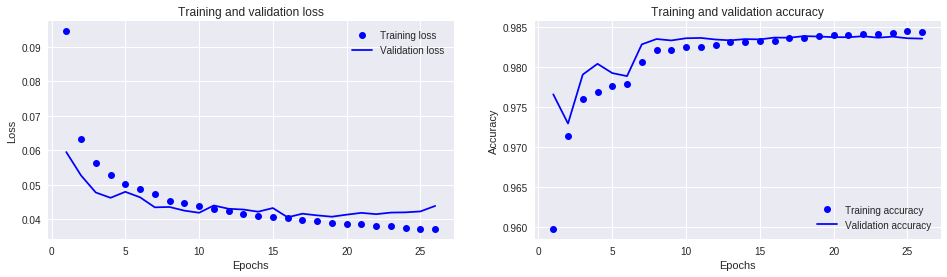

In [14]:
plot_history(history)

In [15]:
print(evaluate_on_test(model))

31915/31915 [==============================] - 52s 2ms/step
([0.04058185552776364, 0.9844848166900837], 0.9894835529984319)
